<a href="https://colab.research.google.com/github/jellyontherock/AI/blob/master/%5BBaseline%5D_Anomaly_Detection_with_IsolationForest_(%EB%B9%84%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

## Data Load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/AI/카드 사기 공모전_데이콘/train.csv') # Train
train_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


In [5]:
val_df = pd.read_csv('/content/drive/MyDrive/AI/카드 사기 공모전_데이콘/val.csv') # Validation
val_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,10,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,22,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,63,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,69,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,83,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


## Train/Validation Feature 분포 확인

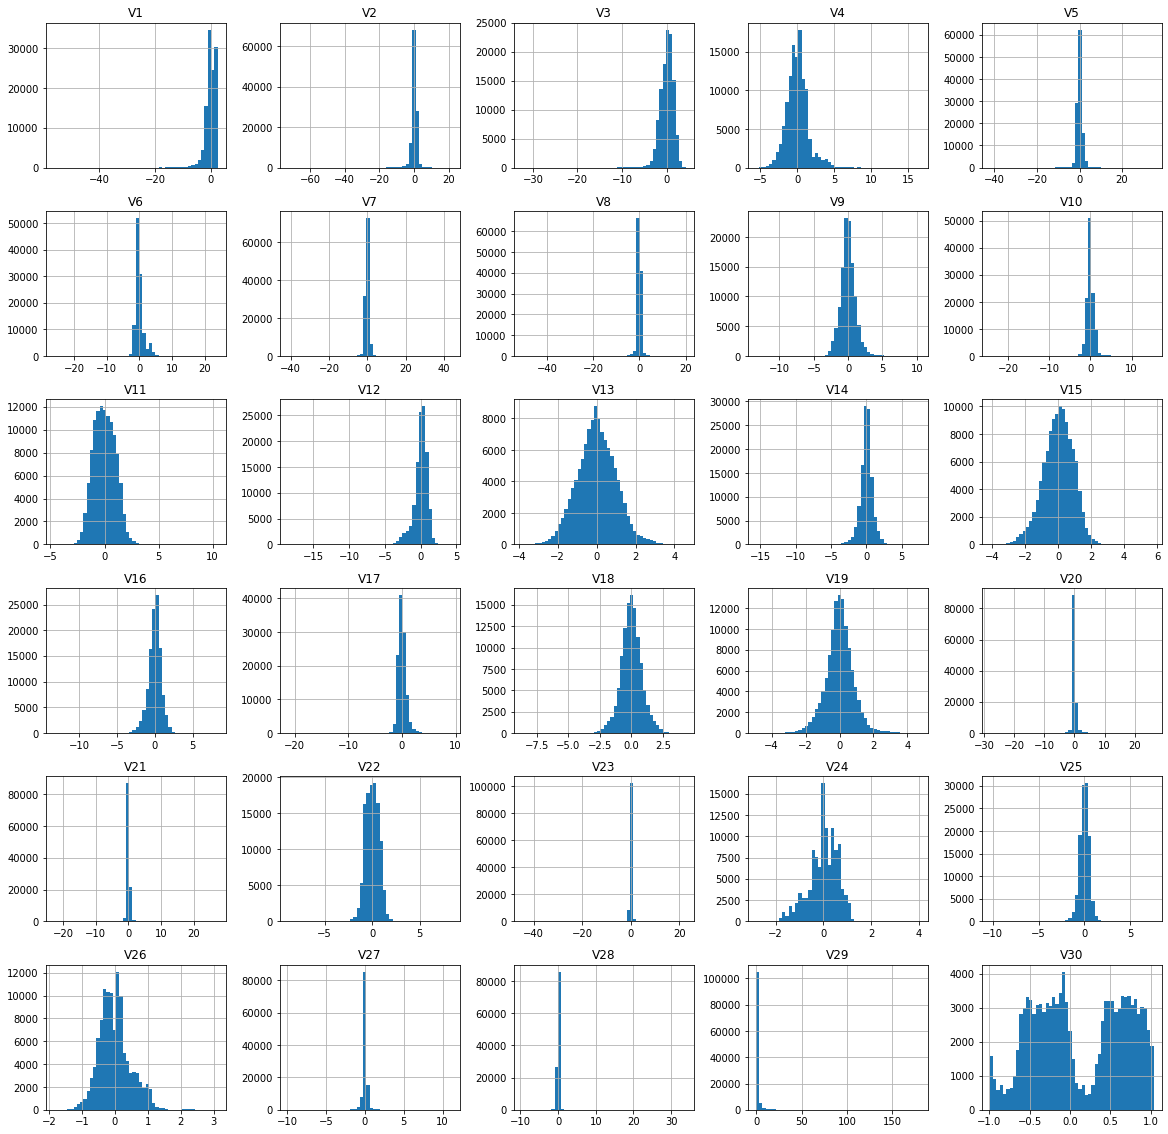

In [6]:
train_df.drop(columns=['ID']).hist(bins = 50, figsize = (20,20))
plt.show()

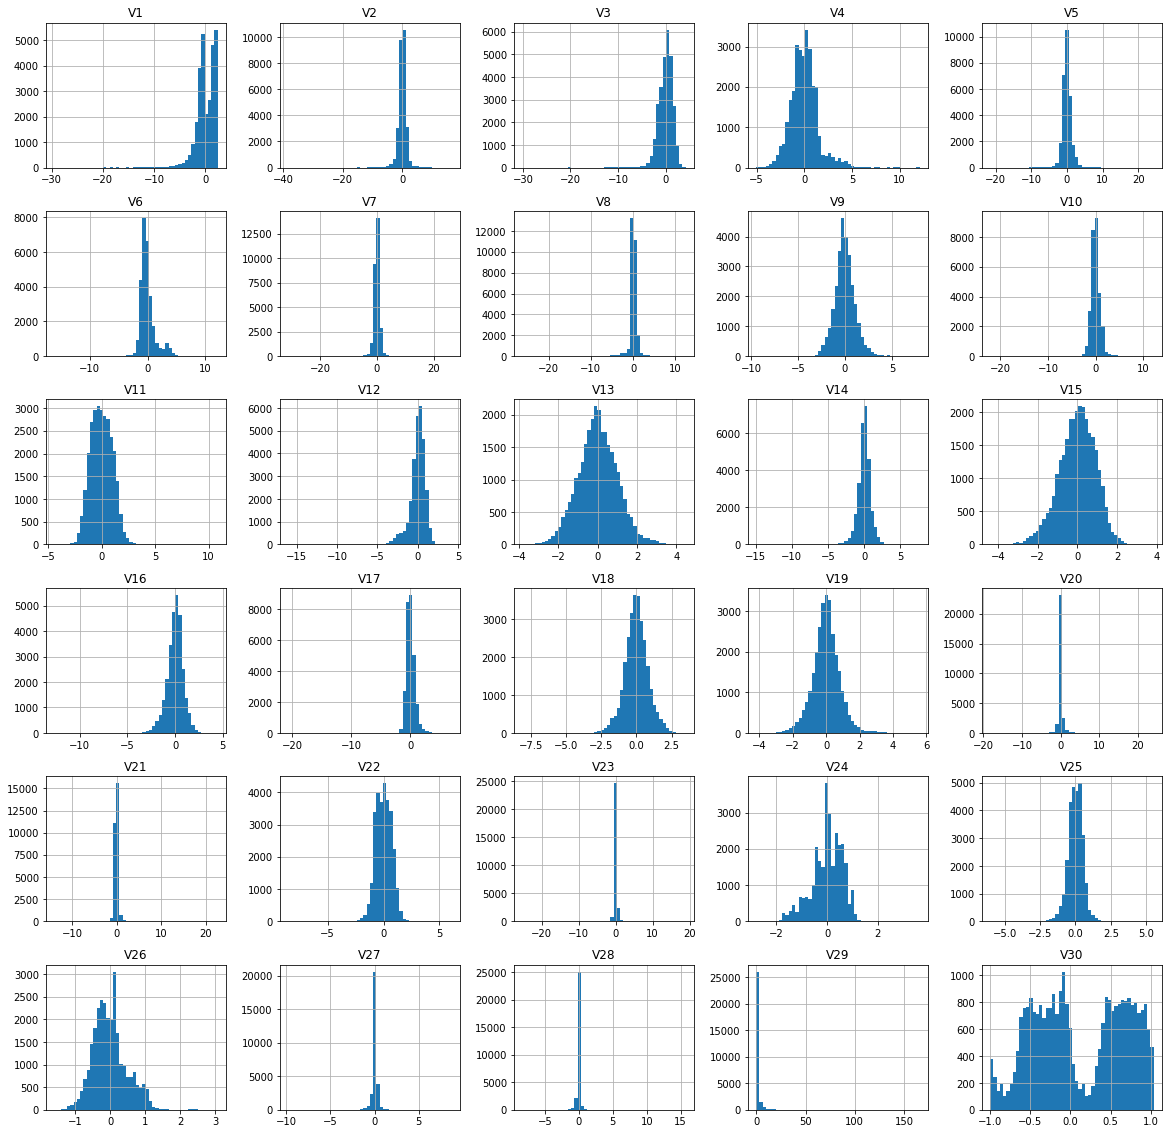

In [ ]:
val_df.drop(columns=['ID', 'Class']).hist(bins = 50, figsize = (20,20))
plt.show()

## Validation set 사기 거래 비율
#### (*) Validation set의 사기 거래 비율이 다른 데이터집합에서도 비슷하게 발생할 것이라고 가정

In [7]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


## Model Define & Fit

In [8]:
# Train dataset은 Label이 존재하지 않음
train_x = train_df.drop(columns=['ID']) # Input Data

In [9]:
# 가설 설정 : Train dataset도 Validation dataset과 동일한 비율로 사기거래가 발생 했을 것이다. -> model parameter : contamination=val_contamination(=0.001055) 적용
model = IsolationForest(n_estimators=125, max_samples=len(train_x), contamination=val_contamination, random_state=42, verbose=0)
model.fit(train_x)

IsolationForest(contamination=0.0010551491277433877, max_samples=113842,
                n_estimators=125, random_state=42)

## Evaluation : Validation set

In [10]:
def get_pred_label(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [11]:
val_x = val_df.drop(columns=['ID', 'Class']) # Input Data
val_y = val_df['Class'] # Label

val_pred = model.predict(val_x) # model prediction
val_pred = get_pred_label(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.7030820840915222]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.41      0.40      0.41        30

    accuracy                           1.00     28462
   macro avg       0.71      0.70      0.70     28462
weighted avg       1.00      1.00      1.00     28462



## Inference : Test set

In [12]:
test_df = pd.read_csv('/content/drive/MyDrive/AI/카드 사기 공모전_데이콘/test.csv') # Train
test_df.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,AAAA0x1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,AAAA0x2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,AAAA0x5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,AAAA0x7,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,AAAA0xc,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [13]:
test_x = test_df.drop(columns=['ID'])

In [14]:
test_pred = model.predict(test_x) # model prediction
test_pred = get_pred_label(test_pred)

## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [ ]:
submit['Class'] = test_pred
submit.to_csv('./submit.csv', index=False)